# Polynômes de chaos avec bootstrap : application au cas de la poutre encastrée


## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment obtenir les indices de Sobol' à partir d'un chaos polynomial.

# Model definition

In [1]:
import openturns as ot

In [2]:
distributionE = ot.Beta(0.9, 3.1, 2.8e7, 4.8e7)
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
distributionL = ot.Uniform(2.50, 2.60)  # En mètres
distributionL.setDescription(["L"])
distributionI = ot.Beta(2.5, 4, 310.0, 450.0)  # in cm^4
distributionI.setDescription(["I"])

myDistribution = ot.JointDistribution([distributionE, distributionF, distributionL, distributionI])

In [3]:
dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * (L**3) / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Create a polynomial chaos decomposition

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [4]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [distributionE, distributionF, distributionL, distributionI]
)

Generate an training sample of size N with MC simulation (or retrieve the design from experimental data).

In [5]:
N = 20  # size of the experimental design

inputTrain = myDistribution.getSample(N)
outputTrain = g(inputTrain)

In [6]:
def ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
):
    """
    Create a sparse polynomial chaos with least squares.

    * Uses the enumeration rule from multivariateBasis.
    * Uses LeastSquaresStrategy to compute the coefficients from
    linear least squares.
    * Uses LeastSquaresMetaModelSelectionFactory to select the polynomials
    in the basis using least angle regression stepwise (LARS)
    * Utilise LeastSquaresStrategy pour calculer les
    coefficients par moindres carrés.
    * Uses FixedStrategy to keep all coefficients that LARS has selected,
    up to the given maximum total degree.

    Parameters
    ----------
    inputTrain : ot.Sample(n)
        The input training design of experiments with n points
    outputTrain : ot.Sample(n)
        The input training design of experiments with n points
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The maximum total polynomial degree
    myDistribution : ot.Distribution
        The distribution of the input random vector

    Returns
    -------
    result : ot.FunctionalChaosResult
        The polynomial chaos result
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumfunc = multivariateBasis.getEnumerateFunction()
    basisSize = enumfunc.getBasisSizeFromTotalDegree(totalDegree)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, basisSize)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result

In [7]:
totalDegree = 2

In [8]:
result = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
)

In [9]:
metamodel = result.getMetaModel()  # get the metamodel

## Validate the metamodel

Generate a validation sample (which is independent of the training sample).

In [10]:
n_valid = 1000
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [12]:
val = ot.MetaModelValidation(outputTest, metamodel(inputTest))

Plot the observed versus the predicted outputs.

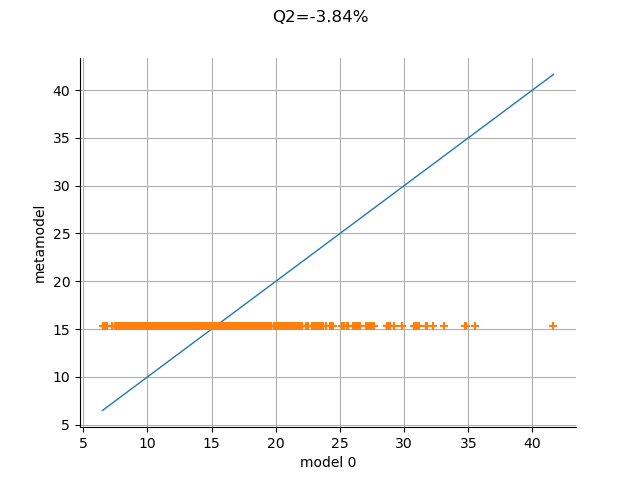

In [13]:
graph = val.drawValidation()
Q2 = val.computeR2Score()[0]
graph.setTitle("Q2=%.2f%%" % (Q2 * 100))
graph

## Sensitivity analysis

Retrieve Sobol' sensitivity measures associated to the polynomial chaos decomposition of the model.

In [14]:
chaosSI = ot.FunctionalChaosSobolIndices(result)

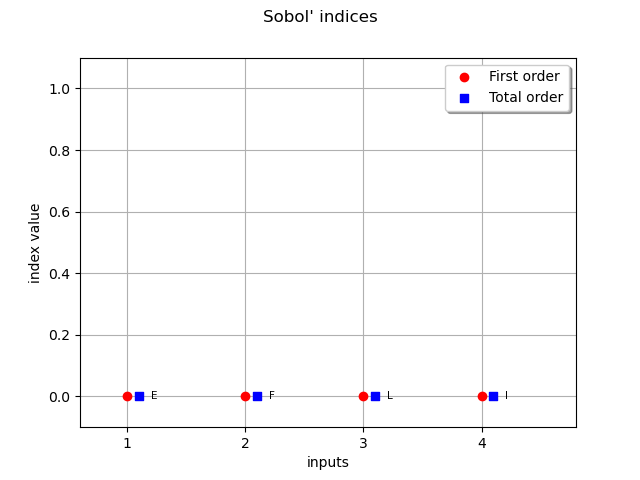

In [15]:
firstOrderIndices = ot.Point([chaosSI.getSobolIndex(i) for i in range(dim_input)])
totalOrderIndices = ot.Point([chaosSI.getSobolTotalIndex(i) for i in range(dim_input)])
input_names = g.getInputDescription()
ot.SobolIndicesAlgorithm.DrawSobolIndices(
    input_names, firstOrderIndices, totalOrderIndices
)

## Par bootstrap

In [16]:
class BootstrapInputOutputSample:
    """
    Creates Bootstrap input/output samples.
    """

    def __init__(self, inputSample, outputSample):
        """
        Creates a Bootstrap input/output samples.

        Parameters :
            inputSample : a Sample, the input
            outputSample : a Sample, the output
        """
        self.sampleSize = inputSample.getSize()
        self.dimInput = inputSample.getDimension()
        self.dimOutput = outputSample.getDimension()
        self.dimTotal = self.dimInput + self.dimOutput
        # Creates the full Sample by joining the input and output
        fullSample = ot.Sample(self.sampleSize, self.dimTotal)
        fullSample[:, 0 : self.dimInput] = inputSample
        fullSample[:, self.dimInput : self.dimTotal] = outputSample
        self.bootstrap = ot.BootstrapExperiment(fullSample)
        return

    def generate(self):
        """
        Returns a pair of (input, output) Sample by bootstraping the initial Sample.
        """
        fullBootstrapSample = self.bootstrap.generate()
        bootstrapInputSample = fullBootstrapSample[:, 0 : self.dimInput]
        bootstrapOutputSample = fullBootstrapSample[:, self.dimInput : self.dimTotal]
        return bootstrapInputSample, bootstrapOutputSample

In [17]:
bootstrapSample = BootstrapInputOutputSample(inputTrain, outputTrain)

In [18]:
bootstrapInputSample, bootstrapOutputSample = bootstrapSample.generate()

In [19]:
bootstrapInputSample[:5, :]

,v0,v1,v2,v3
0,4.337717e+07,23472.8,252.4635,390.3226
1,4.099705e+07,24828.7,255.2469,379.6039
2,2.850904e+07,25401.33,259.5585,391.757
3,2.893585e+07,31125.35,258.5775,348.3433
4,2.817497e+07,37448.62,256.5341,335.8821


In [20]:
bootstrapOutputSample[:5, :]

,v4
0,7.436257
1,8.843631
2,13.25689
3,17.79597
4,22.26893


## Analyse de sensibilité bootstrap

In [21]:
def ComputeChaosSensitivity(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
):
    """
    Computes the first and total order Sobol' indices from a polynomial chaos.

    Parameters:
        inputTrain : un Sample, le plan d'expériences des entrées
        outputTrain : un Sample, le plan d'expériences des sorties
        multivariateBasis : une Basis, la base multivariée du chaos
        totalDegree : un entier, le degré total maximal du chaos
        myDistribution : une Distribution, la loi du vecteur aléatoire en entrée
    """
    dim_input = inputTrain.getDimension()
    result = ComputeSparseLeastSquaresChaos(
        inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
    )
    chaosSI = ot.FunctionalChaosSobolIndices(result)
    first_order = [chaosSI.getSobolIndex(i) for i in range(dim_input)]
    total_order = [chaosSI.getSobolTotalIndex(i) for i in range(dim_input)]
    return first_order, total_order

In [22]:
def ComputeBootstrapChaosSobolIndices(
    bootstrapSampleSize,
    inputTrain,
    outputTrain,
    multivariateBasis,
    totalDegree,
    myDistribution,
):
    """
    Computes a bootstrap sample of first and total order indices from polynomial chaos.

    Parameters:
        bootstrapSampleSize: an integer, the bootstrap sample size
        inputTrain : un Sample, le plan d'expériences des entrées
        outputTrain : un Sample, le plan d'expériences des sorties
        multivariateBasis : une Basis, la base multivariée du chaos
        totalDegree : un entier, le degré total maximal du chaos
        myDistribution : une Distribution, la loi du vecteur aléatoire en entrée
    """
    bootstrapSample = BootstrapInputOutputSample(inputTrain, outputTrain)
    dimInput = inputTrain.getDimension()
    sampleFirstOrderIndices = ot.Sample(bootstrapSampleSize, dimInput)
    sampleTotalOrderIndices = ot.Sample(bootstrapSampleSize, dimInput)
    for i in range(bootstrapSampleSize):
        bootstrapInputSample, bootstrapOutputSample = bootstrapSample.generate()
        first_order, total_order = ComputeChaosSensitivity(
            bootstrapInputSample,
            bootstrapOutputSample,
            multivariateBasis,
            totalDegree,
            myDistribution,
        )
        sampleFirstOrderIndices[i] = first_order
        sampleTotalOrderIndices[i] = total_order
    return sampleFirstOrderIndices, sampleTotalOrderIndices

In [23]:
bootstrapSampleSize = 500
sampleFirstOrderIndices, sampleTotalOrderIndices = ComputeBootstrapChaosSobolIndices(
    bootstrapSampleSize,
    inputTrain,
    outputTrain,
    multivariateBasis,
    totalDegree,
    myDistribution,
)

In [24]:
def ComputeSobolIndicesConfidenceInterval(
    sampleFirstOrderIndices, sampleTotalOrderIndices, alpha=0.95
):
    """
    From a sample of first or total order indices,
    compute a bilateral confidence interval of level alpha.

    Estimates the distribution of the first and total order Sobol' indices
    from a KernelSmoothing estimation.
    Then computes a bilateral confidence interval for each marginal.

    Parameters
    ----------
    sampleFirstOrderIndices: ot.Sample(n, dimInput)
        The first order indices
    sampleTotalOrderIndices: ot.Sample(n, dimInput)
        The total order indices
    alpha : float
        The confidence level

    Returns
    -------
    firstOrderIndicesInterval : ot.Interval
        The 95% confidence interval of first order Sobol' indices
    totalOrderIndicesInterval : ot.Interval
        The 95% confidence interval of total order Sobol' indices
    """
    kernel = ot.KernelSmoothing()
    dimInput = sampleFirstOrderIndices.getDimension()
    firstOrderIndicesLowerBound = ot.Point(dimInput)
    firstOrderIndicesUpperBound = ot.Point(dimInput)
    totalOrderIndicesLowerBound = ot.Point(dimInput)
    totalOrderIndicesUpperBound = ot.Point(dimInput)
    for i in range(dimInput):
        fittedDist = kernel.build(sampleFirstOrderIndices[:, i])
        firstOrderIndicesInterval_i = fittedDist.computeBilateralConfidenceInterval(
            alpha
        )
        firstOrderIndicesLowerBound[i] = firstOrderIndicesInterval_i.getLowerBound()[0]
        firstOrderIndicesUpperBound[i] = firstOrderIndicesInterval_i.getUpperBound()[0]
        fittedDist = kernel.build(sampleTotalOrderIndices[:, i])
        totalOrderIndicesInterval_i = fittedDist.computeBilateralConfidenceInterval(
            alpha
        )
        totalOrderIndicesLowerBound[i] = totalOrderIndicesInterval_i.getLowerBound()[0]
        totalOrderIndicesUpperBound[i] = totalOrderIndicesInterval_i.getUpperBound()[0]
    # Create intervals
    firstOrderIndicesInterval = ot.Interval(
        firstOrderIndicesLowerBound, firstOrderIndicesUpperBound
    )
    totalOrderIndicesInterval = ot.Interval(
        totalOrderIndicesLowerBound, totalOrderIndicesUpperBound
    )
    return firstOrderIndicesInterval, totalOrderIndicesInterval

In [25]:
alpha = 0.95
(
    firstOrderIndicesInterval,
    totalOrderIndicesInterval,
) = ComputeSobolIndicesConfidenceInterval(
    sampleFirstOrderIndices, sampleTotalOrderIndices, alpha
)

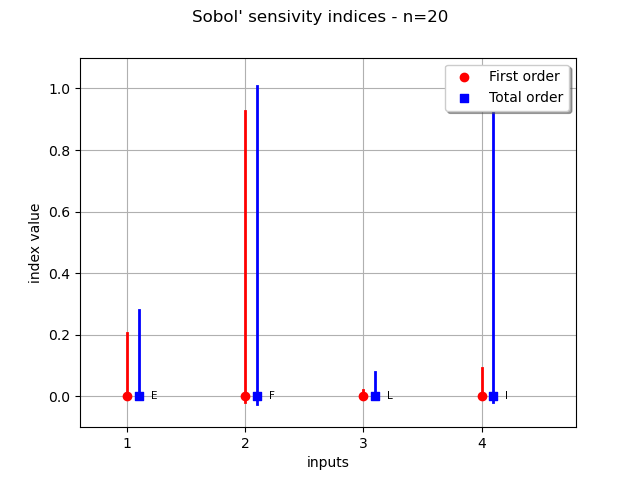

In [26]:
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(
    input_names,
    firstOrderIndices,
    totalOrderIndices,
    firstOrderIndicesInterval,
    totalOrderIndicesInterval,
)
sampleSize = inputTrain.getSize()
graph.setTitle("Sobol' sensivity indices - n=%d" % (sampleSize))
graph

In [27]:
def ComputeAndDrawSobolIndices(
    sampleSize,
    multivariateBasis,
    totalDegree,
    myDistribution,
    bootstrapSampleSize=500,
    alpha=0.95,
):
    """
    Compute and draw Sobol' indices from a polynomial chaos based on a
    given sample size.
    Compute confidence intervals at level alpha from bootstrap.
    """
    inputTrain = myDistribution.getSample(sampleSize)
    outputTrain = g(inputTrain)
    #
    (
        sampleFirstOrderIndices,
        sampleTotalOrderIndices,
    ) = ComputeBootstrapChaosSobolIndices(
        bootstrapSampleSize,
        inputTrain,
        outputTrain,
        multivariateBasis,
        totalDegree,
        myDistribution,
    )
    #
    (
        firstOrderIndicesInterval,
        totalOrderIndicesInterval,
    ) = ComputeSobolIndicesConfidenceInterval(
        sampleFirstOrderIndices, sampleTotalOrderIndices, alpha
    )
    #
    graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(
        input_names,
        firstOrderIndices,
        totalOrderIndices,
        firstOrderIndicesInterval,
        totalOrderIndicesInterval,
    )
    graph.setTitle("Sobol' sensivity indices - n=%d" % (sampleSize))
    return graph

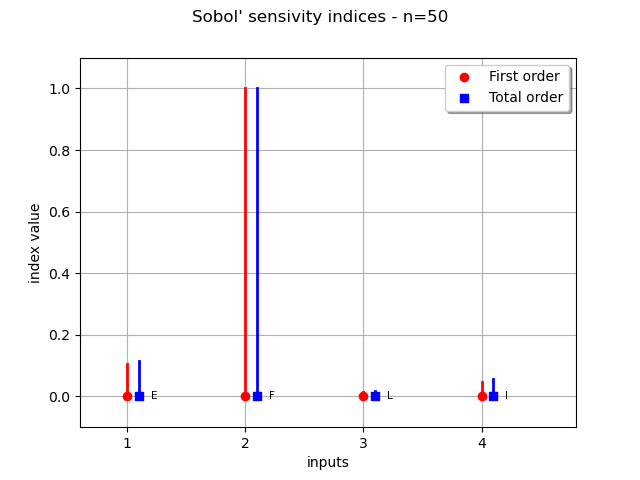

In [28]:
N = 50  # size of the experimental design
ComputeAndDrawSobolIndices(N, multivariateBasis, totalDegree, myDistribution)

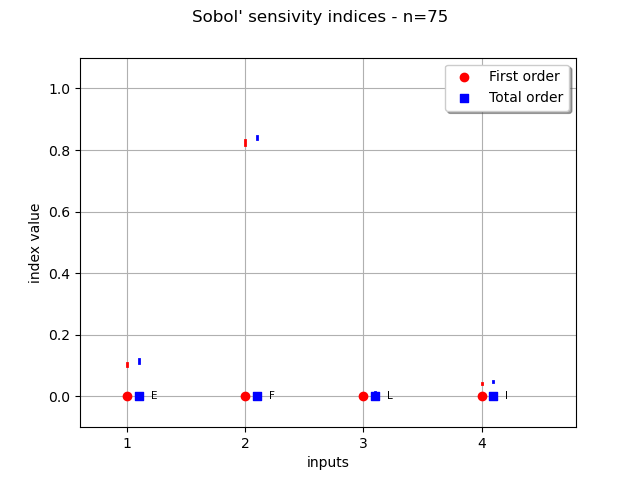

In [29]:
N = 75  # size of the experimental design
ComputeAndDrawSobolIndices(N, multivariateBasis, totalDegree, myDistribution)

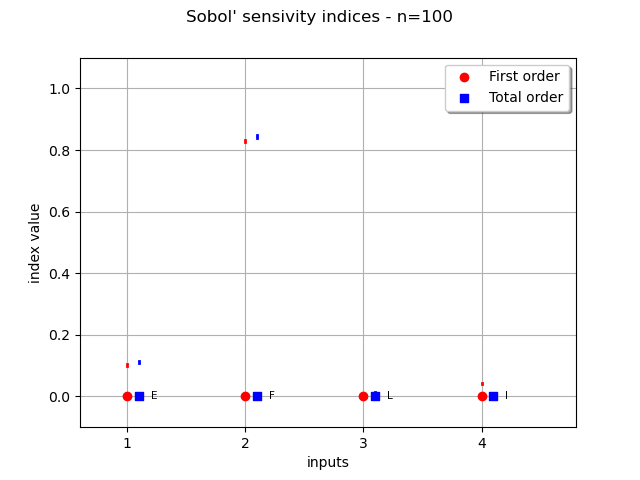

In [30]:
N = 100  # size of the experimental design
ComputeAndDrawSobolIndices(N, multivariateBasis, totalDegree, myDistribution)